![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 -  Object Detection </center>
### <center> Object Localization </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_ObjectDetection/MainObjectLocalization.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_ObjectDetection/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
#-----------------------------------------------------------#
#-----------------------------------------------------------#
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR
#-----------------------------------------------------------#
#-----------------------------------------------------------#
from DeepLearningFramework.Utils import PlotImage
#-----------------------------------------------------------#
#-----------------------------------------------------------#
torch.set_printoptions(3, linewidth=120, sci_mode=False)
torch.backends.cudnn.benchmark = True

#### Constants:

In [5]:
IMAGE_SIZE = 100
LABELS     = ['R', 'G', 'B']

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### `CreateImage` creates a synthetic image for object detection:

In [6]:
from DeepLearningFramework.ObjectLocalizationUtils import CreateImage
#----------------------------------------------------------#
#----------------------------------------------------------#
mI, mBBox = CreateImage(IMAGE_SIZE, 1)
mBBox

tensor([[2.000, 0.700, 0.232, 0.155, 0.464]])

#### BBox:
```python
mBBox.shape = (1, 5)
mBBox[ii]   = (label, xCetnter, yCenter, width, height)
```

#### A useful function to plot an image with its bounding boxes
```python
from DeepLearningFramework.Utils import PlotImage
```

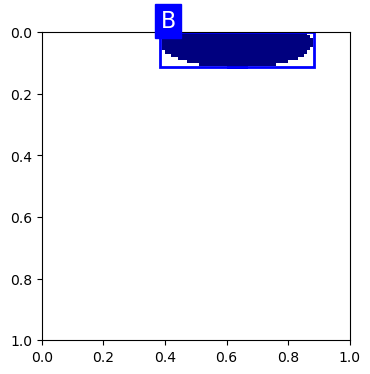

In [7]:
mI, mBBox = CreateImage(IMAGE_SIZE, 1)
PlotImage(mI, mBBox, LABELS, lColors=np.eye(3))
plt.show ()

#### Create synthetic datasets:

In [8]:
def MakeData(N):
    mX    = torch.empty(N, 3, IMAGE_SIZE, IMAGE_SIZE)
    mBBox = torch.empty(N, 5)
    for ii in range(N):
        mXi, mBi  = CreateImage(IMAGE_SIZE, 1)
        mX   [ii] = mXi
        mBBox[ii] = mBi[0]

    return mX, mBBox
        
nTrain = 10000
nTest  = 1000

mTrainX, mTrainBBox = MakeData(nTrain)
mTestX,  mTestBBox  = MakeData(nTest)

### Define a `Dataset` class.
In this example one can also use `torch.utils.data.TensorDataset`.  
However, it is important to know how to define a custom dataset.

In [9]:
if False:
    class ObjectLocalizationDataset(torch.utils.data.Dataset):
        def __init__(self, mX, mBBox):
            self.mX    = mX
            self.mBBox = mBBox

        def __len__(self):
            return self.mX.shape[0]

        def __getitem__(self, idx):
            mXi = self.mX   [idx]
            mBi = self.mBBox[idx]
            return mXi, mBi

#### Create train and test sets:
To allow multiprocessing (in Windows) we import the dataset from a file.

In [10]:
from DeepLearningFramework.ObjectLocalizationUtils import ObjectLocalizationDataset

oTrainSet = ObjectLocalizationDataset(mTrainX, mTrainBBox)
oTestSet  = ObjectLocalizationDataset(mTestX,  mTestBBox)

#### Test our dataset code:

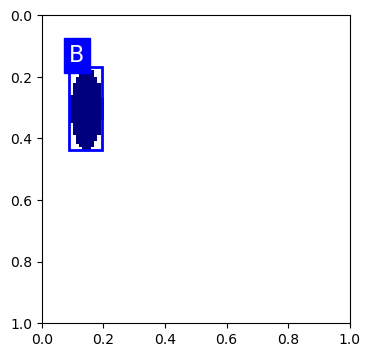

In [11]:
idx      = np.random.randint(nTrain)
mXi, mBi = oTrainSet[idx]

PlotImage(mXi, mBi[None], vLabels=LABELS, lColors=np.eye(3))
plt.show ()

#### Data-loader:

In [12]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       mBBox       = next(iter(oTrainDL))
mX.shape, mBBox.shape

(torch.Size([256, 3, 100, 100]), torch.Size([256, 5]))

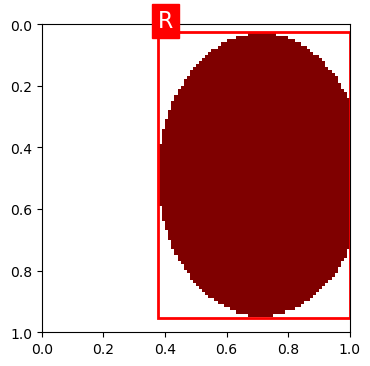

In [13]:
mX, mBBox = next(iter(oTrainDL))

PlotImage(mX[0], mBBox[[0]], vLabels=LABELS, lColors=np.eye(3))
plt.show ()

#### Define the model:

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.NN = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(3,   32,  3, stride=2, padding=0, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(),
            nn.Conv2d(32,  32,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(),
            nn.Conv2d(32,  32,  3, stride=2, padding=0, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(),
            nn.Conv2d(32,  32,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(),
            nn.Conv2d(32,  32,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(),
            nn.Conv2d(32,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(),
            nn.Conv2d(64,  128, 3, stride=1, padding=0, bias=False), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=0, bias=False), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 2, stride=1, padding=0, bias=False), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 7,   1, stride=1, padding=0, bias=True ),
            nn.Flatten()
    )
        
    def forward(self, mX):
        mOutput = self.NN(mX)
                
        return mOutput
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
#-- Model summary:
mOutput = Model()(mX)

mOutput.shape, \
torchinfo.summary(Model(), mX.shape)

(torch.Size([256, 7]),
 Layer (type:depth-idx)                   Output Shape              Param #
 Model                                    --                        --
 ├─Sequential: 1-1                        [256, 7]                  --
 │    └─Identity: 2-1                     [256, 3, 100, 100]        --
 │    └─Conv2d: 2-2                       [256, 32, 49, 49]         864
 │    └─BatchNorm2d: 2-3                  [256, 32, 49, 49]         64
 │    └─ReLU: 2-4                         [256, 32, 49, 49]         --
 │    └─Conv2d: 2-5                       [256, 32, 49, 49]         9,216
 │    └─BatchNorm2d: 2-6                  [256, 32, 49, 49]         64
 │    └─ReLU: 2-7                         [256, 32, 49, 49]         --
 │    └─Conv2d: 2-8                       [256, 32, 24, 24]         9,216
 │    └─BatchNorm2d: 2-9                  [256, 32, 24, 24]         64
 │    └─ReLU: 2-10                        [256, 32, 24, 24]         --
 │    └─Conv2d: 2-11                      

### Loss function (regression + classification):
$$\ell\left(\hat{\boldsymbol{y}},\boldsymbol{y}\right)=\lambda_{\text{MSE}}\cdot\ell_{\text{MSE}}\left(\hat{\boldsymbol{y}}_{\text{bbox}},\boldsymbol{y}_{\text{bbox}}\right)+\lambda_{\text{CE}}\cdot\ell_{\text{CE}}\left(\hat{\boldsymbol{y}}_{\text{label}},\boldsymbol{y}_{\text{label}}\right)$$
where $\lambda_{\text{MSE}}$ and $\lambda_{\text{CE}}$ are the weights
of each loss.

In [15]:
def Loss(mOutput, mBBox):
    #-- mOutput.shape = (N, 7)
    #-- mBBox  .shape = (N, 5)
    #-- mOutput[ii,:] = [R, G, B, x, y, W, H]
    #-- mBBox  [ii,:] = [cIdx,    x, y, W, H]
    vLabel     = mBBox  [:,0 ].type(torch.long)
    mBBox      = mBBox  [:,1:]
    mLabelPred = mOutput[:,:3]
    mBBoxPred  = mOutput[:,3:]
    
    MSE = nn.MSELoss         ()(mBBoxPred,  mBBox)
    CE  = nn.CrossEntropyLoss()(mLabelPred, vLabel)
    
    loss = 20 * MSE + CE
    
    return loss, MSE.item(), CE.item()

### Exercise 1: IoU
Implement the `ComputeIoU_Ex` funciton.
$$\text{IoU}\left(B_{i},B_{j}\right)=\frac{\text{Area}\left(B_{i}\cap B_{j}\right)}{\text{Area}\left(B_{i}\cup B_{j}\right)}$$

* You may use the `Area` and `CenterToCorner` functions.

In [16]:
def Area(mBBox):
    #-- mBBox.shape = (N, 4)
    #-- mBBox[ii,:] = [xLeft, yUp, xRight, yDown]
    
    vXLeft, vYUp, vXRight, vYDown = mBBox.T
    return (vXRight - vXLeft).clamp(0) * (vYDown - vYUp).clamp(0)
#--------------------------------------------------------------------------#
#--------------------------------------------------------------------------#
def CenterToCorner(mBBox):
    #-- mBBox.shape = (N, 4)
    #-- mBBox[ii,:] = [xCenter, yCenter, width, height]
    vX, vY, vW, vH = mBBox.T
    vXLeft         = vX - vW / 2
    vXRight        = vX + vW / 2
    vYUp           = vY - vH / 2
    vYDown         = vY + vH / 2
    mBBox          = torch.stack([vXLeft, vYUp, vXRight, vYDown], dim=-1)

    return mBBox
#--------------------------------------------------------------------------#
#--------------------------------------------------------------------------#
def ComputeIoU_Ex(mBBox1, mBBox2):
    #-- mBBox1.shape = (N, 4)
    #-- mBBox2.shape = (N, 4)
    #-- mBBox1[ii,:] = [xCenter, yCenter, width, height]
    #-- mBBox2[ii,:] = [xCenter, yCenter, width, height]

#     vIoU = ??? #-- vIoU.shape = (N,)
#     return vIoU
    
    return torch.randn(mBBox1.shape[0])

#### Test your implementation:

In [17]:
from DeepLearningFramework.ObjectLocalizationUtils import ComputeIoU

mBBox1 = torch.rand(10, 4)
mBBox2 = torch.rand(10, 4)
mIoU1  = ComputeIoU   (mBBox1, mBBox2)
mIoU2  = ComputeIoU_Ex(mBBox1, mBBox2)

if torch.abs(mIoU1 - mIoU2).max() < 1e-10:
    print('Success!')
else:
    print('Fail!')

Fail!


### Exercise 2: Metric
Implement the following metric.
$$\text{Metric}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{I}\left\{ \hat{y}_{i}=y_{i}\right\} \cdot\text{IoU}\left(\hat{B}_{i},B_{i}\right)$$
where:
- $\hat{y}_{i}$ is the predicted label
- $y_{i}$ is the correct label
- $\hat{B}_{i}$ is the predicted bounding box
- $B_{i}$ is the correct bounding box
In other words, the average IoU, considering only correct (label) prediction.

In [18]:
def Output2Target(mOutput):
    #-- mOutput.shape = (N, 7)
    #-- mOutput[ii,:] = [R, G, B, x, y, W, H]
    mClass = torch.argmax(mOutput[:,:3], dim=1, keepdims=True) #-- mClass.shape = (N, 1)
    mBBox  =              mOutput[:,3:]                        #-- mBBox .shape = (N, 4)
    mBBox  = torch.cat   ([mClass, mBBox], dim=1)              #-- mBBox .shape = (N, 5)
    return mBBox

In [19]:
def Metric_Ex(mOutput, mBBox):
    #-- mOutput.shape = (N, 7)
    #-- mBBox  .shape = (N, 5)
    #-- mOutput[ii,:] = [R, G, B, x, y, W, H]
    #-- mBBox  [ii,:] = [cIdx,    x, y, W, H]
    
    mBBoxPred  = Output2Target(mOutput) #-- mBBoxPred[ii,:] = [cIdx, x, y, W, H]
    vLabelPred = mBBoxPred[:,0]
    vLabel     = mBBox    [:,0]
    mBBoxPred  = mBBoxPred[:,1:]
    mBBox      = mBBox    [:,1:]

#     vIoU       = ???
#     vCorrect   = ???

#     acc        = vCorrect.mean().item()
#     IoU        = vIoU    .mean().item()
#     metric     = ???
    
#     return metric, acc, IoU
    return 0, 0, 0

#### Test your implementation:

In [20]:
from DeepLearningFramework.ObjectLocalizationUtils import Metric

mBBox   = torch.cat([torch.randint(0, 3, (1000, 1)), torch.rand(1000, 4)], dim=1)
mOutput = torch.rand(1000, 7)
metric1 = Metric   (mOutput, mBBox)[0]
metric2 = Metric_Ex(mOutput, mBBox)[0]

if np.abs(metric1 - metric2) < 1e-10:
    print('Success!')
else:
    print('Fail!')

Fail!


In [21]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    vEpochStats = np.zeros(6) #-- (Loss, CE, MSE, Metric, Accuracy, IoU)
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, mBBox) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX    = mX   .to(DEVICE)
        mBBox = mBBox.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut          = oModel(mX)
            loss, MSE, CE = Loss  (mOut, mBBox)

            #-- Backward:
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
        
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut          = oModel(mX)
                loss, MSE, CE = Loss  (mOut, mBBox)

        with torch.no_grad():
            Nb                = mBBox.shape[0]
            metric, acc, IoU  = Metric(mOut, mBBox)
            vIterStats        = np.array([loss.item(), CE, MSE, metric, acc, IoU])
            vEpochStats      += Nb * vIterStats
            count            += Nb
            
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss.item():6.3f}', end='')

    print('', end='\r')
    vEpochStats /= count
    
    return vEpochStats

In [22]:
import time

def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, sModelName='ObjectLocalization'):

    TRAIN        = 0
    VAL          = 1
    mHistory     = np.full((2, 6, nEpochs), np.nan)
    lNames       = ['Loss', 'CE', 'MSE', 'Metric', 'Accuracy', 'IoU']
    bestMetric   = -float('inf')

    fig, _ = plt.subplots(2, 3, figsize=(12, 6))
    for epoch in range(nEpochs):
        startTime               = time.time()
        mHistory[TRAIN,:,epoch] = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        mHistory[VAL,  :,epoch] = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime               = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch                   :03d}:',   end='')
        print(' | Train loss: '   f'{mHistory[TRAIN,0,epoch] :6.3f}',   end='')
        print(' | Val loss: '     f'{mHistory[VAL,  0,epoch] :6.3f}',   end='')
        print(' | Train Metric: ' f'{mHistory[TRAIN,3,epoch] :6.3f}',   end='')
        print(' | Val Metric: '   f'{mHistory[VAL,  3,epoch] :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime               :6.3f} |', end='')

        valMetric = mHistory[VAL,3,epoch]
        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')
            
        for ii, ax in enumerate(fig.axes):
            ax.cla      ()
            ax.plot     (mHistory[TRAIN, ii], 'b', label='Train')
            ax.plot     (mHistory[VAL,   ii], 'r', label='Validation')
            ax.set_title(lNames[ii])
            ax.grid     ()
            ax.legend   ()

        fig.canvas.draw ()
        plt.tight_layout()
        plt.pause       (1e-4)

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return mHistory

<IPython.core.display.Javascript object>


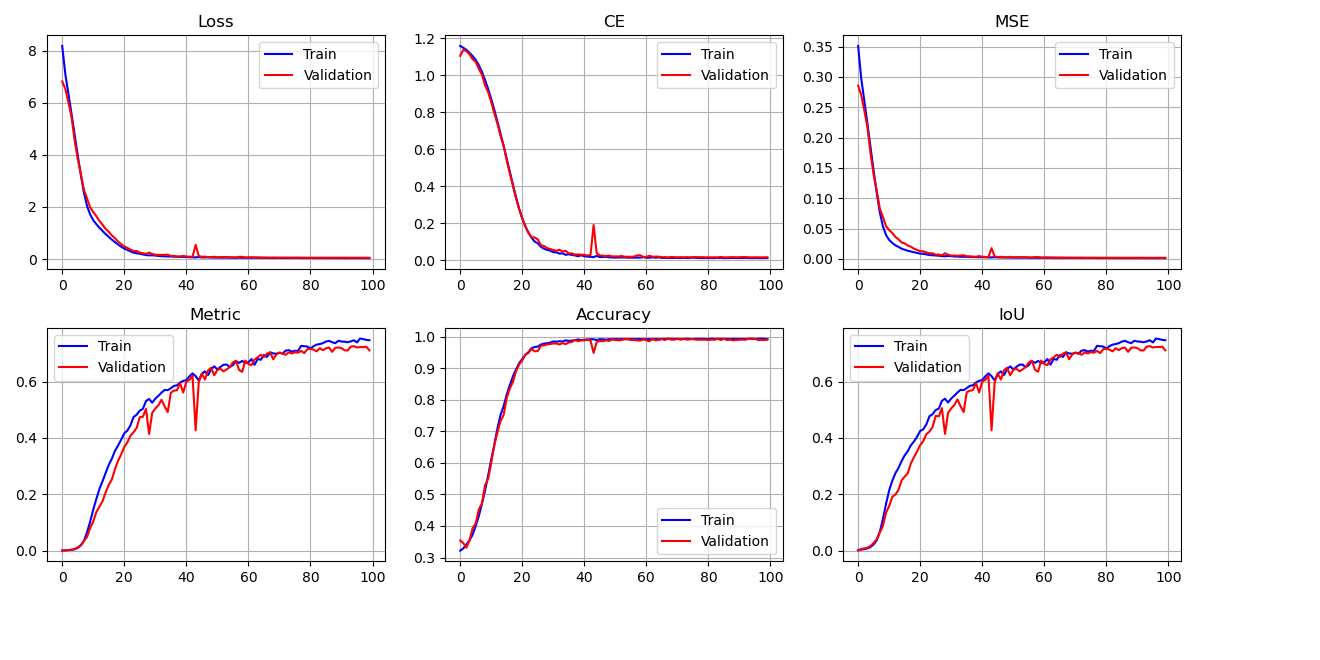

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  8.179 | Val loss:  6.817 | Train Metric:  0.000 | Val Metric:  0.000 | epoch time:  5.980 | <-- Checkpoint!
Epoch 001: | Train loss:  7.098 | Val loss:  6.535 | Train Metric:  0.001 | Val Metric:  0.001 | epoch time:  2.060 | <-- Checkpoint!
Epoch 002: | Train loss:  6.345 | Val loss:  6.017 | Train Metric:  0.002 | Val Metric:  0.002 | epoch time:  2.090 | <-- Checkpoint!
Epoch 003: | Train loss:  5.581 | Val loss:  5.456 | Train Metric:  0.003 | Val Metric:  0.003 | epoch time:  2.114 | <-- Checkpoint!
Epoch 004: | Train loss:  4.782 | Val loss:  4.560 | Train Metric:  0.005 | Val Metric:  0.006 | epoch time:  2.128 | <-- Checkpoint!
Epoch 005: | Train loss:  3.984 | Val loss:  3.853 | Train Metric:  0.010 | Val Metric:  0.011 | epoch time:  2.120 | <-- Checkpoint!
Epoch 006: | Train loss:  3.227 | Val loss:  3.280 | Train Metric:  0.019 |

In [23]:
%matplotlib notebook

nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-5)
oScheduler = OneCycleLR (oOptim, max_lr=7e-5, total_steps=nIter)
mHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler)

In [29]:
# oModel.load_state_dict(torch.load('ObjectLocalization_v1.pt'))
# oModel.train(False);

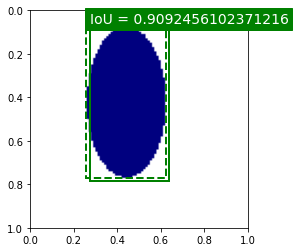

In [30]:
#%matplotlib inline

from DeepLearningFramework.ObjectLocalizationUtils import PlotPredictions

mXi, vBBox = oTestSet[np.random.randint(nTest)]
with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE)).detach().cpu()
    
mBBoxPred = Output2Target(mOutput)[0]
PlotPredictions(mXi, vBBox, mBBoxPred)
plt.show       ()

In [25]:
# def ComputeIoU(mBBox1, mBBox2):
#     #-- mBBox1.shape = (N, 4)
#     #-- mBBox2.shape = (N, 4)
#     #-- mBBox1[ii,:] = [xCenter, yCenter, width, height]
#     #-- mBBox2[ii,:] = [xCenter, yCenter, width, height]
#     mBBox1 = CenterToCorner(mBBox1)
#     mBBox2 = CenterToCorner(mBBox2)

#     mXLeft1, vYUp1, vXRight1, vYDown1  = mBBox1.T
#     vXLeft2, vYUp2, vXRight2, vYDown2  = mBBox2.T
    
#     vXLeft  = torch.maximum(mXLeft1,  vXLeft2 )
#     vXRight = torch.minimum(vXRight1, vXRight2)
#     vYUp    = torch.maximum(vYUp1,    vYUp2   )
#     vYDown  = torch.minimum(vYDown1,  vYDown2 )

#     mBBoxI  = torch.stack([vXLeft, vYUp, vXRight, vYDown], dim=1)
   
#     vArea1 = Area(mBBox1)
#     vArea2 = Area(mBBox2)
#     vAreaI = Area(mBBoxI)
    
#     vIoU   = vAreaI / (vArea1 + vArea2 - vAreaI) #-- vIoU.shape = (N,)
    
#     return vIoU

In [26]:
# def Metric(mOutput, mBBox):
#     #-- mOutput.shape = (N, 7)
#     #-- mBBox  .shape = (N, 5)
#     #-- mOutput[ii,:] = [R, G, B, x, y, W, H]
#     #-- mBBox  [ii,:] = [cIdx,    x, y, W, H]
    
#     mBBoxPred  = Output2Target(mOutput) #-- mBBoxPred[ii,:] = [cIdx, x, y, W, H]
#     vLabelPred = mBBoxPred[:,0]
#     vLabel     = mBBox    [:,0]
#     mBBoxPred  = mBBoxPred[:,1:]
#     mBBox      = mBBox    [:,1:]
#     vIoU       = ComputeIoU(mBBoxPred, mBBox)
#     vCorrect   = (vLabelPred == vLabel).type(torch.float32)

#     acc        = vCorrect.mean()            .item()
#     IoU        = vIoU    .mean()            .item()
#     metric     = torch.inner(vIoU, vCorrect).item() / mBBox.shape[0]
    
#     return metric, acc, IoU